In [126]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter("ignore")

In [127]:
def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.drop('White Blood Cell Count', 'Color')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(1)
    y_closest = t.row(0).item(2)
    ckd.scatter('Hemoglobin', 'Glucose', group='Color')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

In [128]:
def plot_all_points(test_grid):
    test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);
    
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

def plot_all_points_classified(test_grid):
    c = classify_grid(ckd.drop('White Blood Cell Count', 'Color'), test_grid, 1)
    test_grid = test_grid.with_column('Class', c).join('Class', color_table)
    test_grid.scatter('Hemoglobin', 'Glucose', group='Color', alpha=0.4, s=30)

    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);

## Lecture 27

**Datasets**

In [129]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(6)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1


In [130]:
banknotes = Table.read_table('banknote.csv')
banknotes.show(6)

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0


## Classification Examples

### `ckd` dataset

In [131]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)
ckd.show(6)

Class,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Color
0,40,80,1.025,0,0,normal,normal,notpresent,notpresent,140,10,1.2,135,5,15,48,10400,4.5,no,no,no,good,no,no,gold
0,23,80,1.025,0,0,normal,normal,notpresent,notpresent,70,36,1,150,4.6,17,52,9800,5,no,no,no,good,no,no,gold
0,45,80,1.025,0,0,normal,normal,notpresent,notpresent,82,49,0.6,147,4.4,15.9,46,9100,4.7,no,no,no,good,no,no,gold
0,57,80,1.025,0,0,normal,normal,notpresent,notpresent,119,17,1.2,135,4.7,15.4,42,6200,6.2,no,no,no,good,no,no,gold
0,51,60,1.025,0,0,normal,normal,notpresent,notpresent,99,38,0.8,135,3.7,13,49,8300,5.2,no,no,no,good,no,no,gold
0,34,80,1.025,0,0,normal,normal,notpresent,notpresent,121,27,1.2,144,3.9,13.6,52,9200,6.3,no,no,no,good,no,no,gold


In [132]:
ckd.group('Class')

Class,count
0,115
1,43


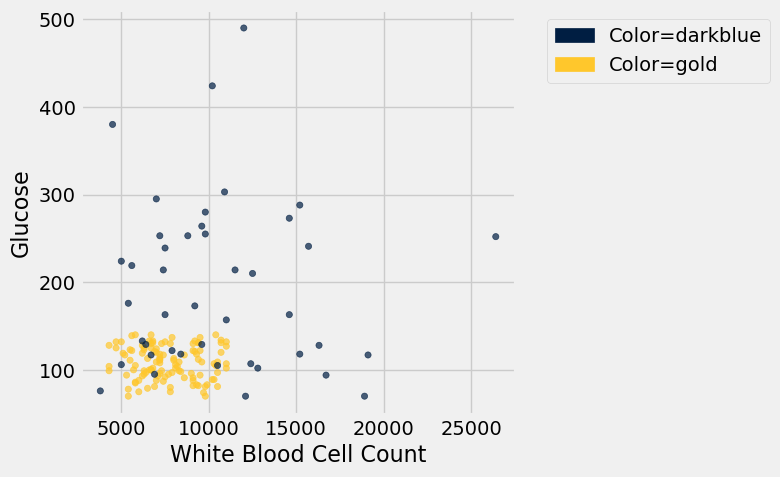

In [133]:
ckd.scatter('White Blood Cell Count', 'Glucose', group='Color')

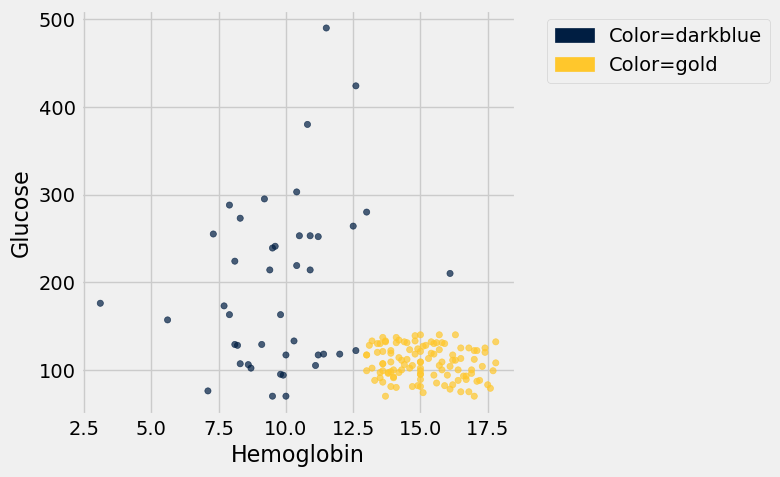

In [134]:
ckd.scatter('Hemoglobin', 'Glucose', group='Color')

We want to be able to way to predict the class of someone without having to plot & eye ball this graph every time.
-  one way to do this is to put some thresholds into our code.

****Manual classification****

In [135]:
max_glucose_for_0 = ckd.where('Class',are.equal_to(0)).column('Glucose').max()
min_hemoglobin_for_0 = ckd.where('Class',are.equal_to(0)).column('Hemoglobin').min()

In [136]:
max_glucose_for_0, min_hemoglobin_for_0

(140, 13.0)

In [137]:
def classify_manually(hemoglobin, glucose):
    if hemoglobin < min_hemoglobin_for_0 or glucose > max_glucose_for_0:
        return 1
    else:
        return 0

In [138]:
classify_manually(15, 100)

0

In [139]:
classify_manually(10, 300)

1

### `banknote` dataset

In [140]:
banknotes.show(3)

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0


In [141]:
banknotes.group('Class')

Class,count
0,762
1,610


**Two-variable patterns**

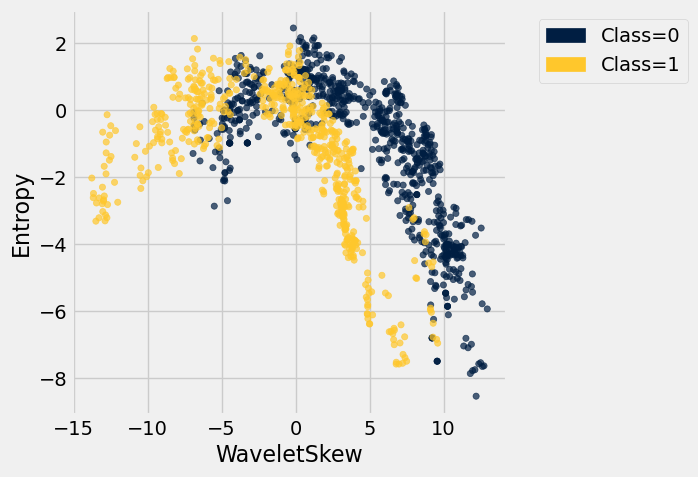

In [142]:
banknotes.scatter('WaveletSkew', 'Entropy', group='Class')

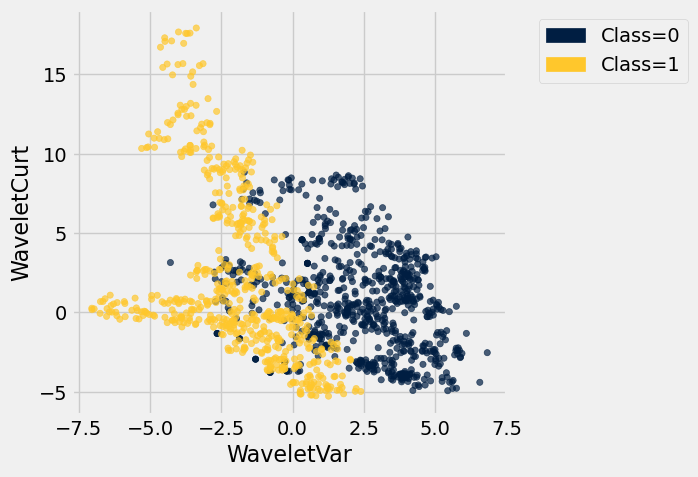

In [143]:
banknotes.scatter('WaveletVar', 'WaveletCurt', group='Class')

**Three-variable patterns**

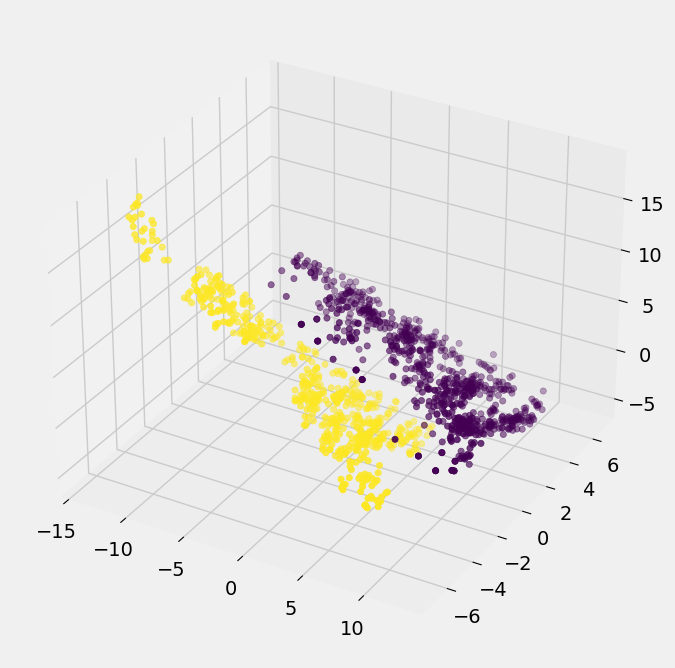

In [144]:
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'));

**STOP**

## Nearest Neighbor Classifier

We will be working with standard units, like usual!

In [145]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

In [146]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

In [147]:
ckd.show(3)

Hemoglobin,Glucose,White Blood Cell Count,Class
0.456884,0.133751,0.617283,0
1.153,-0.947597,0.424788,0
0.770138,-0.762223,0.200211,0


In [148]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)
ckd.show(6)

Class,Hemoglobin,Glucose,White Blood Cell Count,Color
0,0.456884,0.133751,0.617283,gold
0,1.153,-0.947597,0.424788,gold
0,0.770138,-0.762223,0.200211,gold
0,0.596108,-0.190654,-0.73018,gold
0,-0.239236,-0.49961,-0.0564489,gold
0,-0.0304002,-0.159758,0.232293,gold


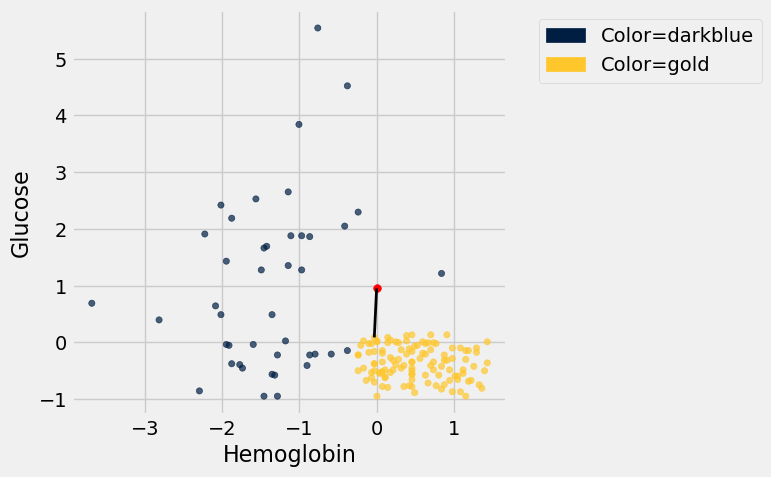

In [149]:
alice = make_array(0, 0.95)
show_closest(alice)

### Decision boundary

In [150]:
# Create a grid of all points
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)

test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

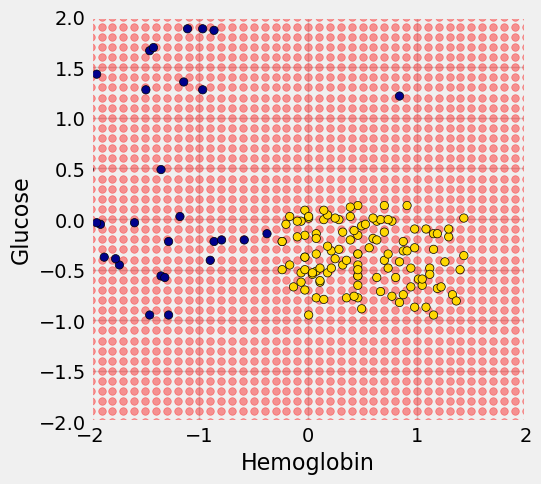

In [151]:
plot_all_points(test_grid)

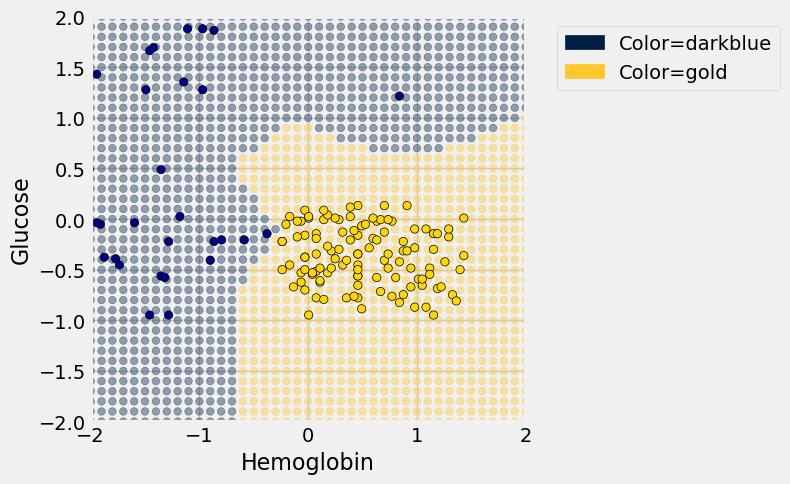

In [152]:
plot_all_points_classified(test_grid)

## Rows of Tables

In [153]:
ckd_attributes = ckd.select('Hemoglobin', 'Glucose')
ckd_attributes

Hemoglobin,Glucose
0.456884,0.133751
1.153,-0.947597
0.770138,-0.762223
0.596108,-0.190654
-0.239236,-0.49961
-0.0304002,-0.159758
0.282854,-0.00527964
0.108824,-0.623193
0.0740178,-0.515058
0.83975,-0.422371


In [154]:
ckd_attributes.row(0)

Row(Hemoglobin=0.45688370171598619, Glucose=0.13375085451774507)

In [155]:
ckd_attributes.row(0).item(1)

0.13375085451774507

In [156]:
np.array(ckd_attributes.row(0))

array([ 0.4568837 ,  0.13375085])

## Implementing the Classifier

### Classifiying in two dimensions

**Finding the distance between two points**

$$ \text{D} = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2} $$

**Finding a distance from Alice for one point**

In [157]:
alice = make_array(0, 1.1)

In [158]:
patient3 = ckd_attributes.row(2)

In [159]:
distance = np.sqrt(np.sum((alice - patient3)**2))
distance

2.0151893412461694

In [164]:
def distance_from_alice(row):
    """Returns distance between Alice and a row of the attributes table"""
    return distance(alice, np.array(row))

In [165]:
distance_from_alice(ckd_attributes.row(3))

1.4216649188818478

**Finding the distance from Alice for all rows**

Use `tbl.apply()` to do `distance()` on every row. *This is the power of treating rows as arrays*.

In [166]:
distances = ckd_attributes.apply(distance_from_alice)
ckd_with_distances = ckd.with_column('Distance from Alice', distances)

In [167]:
ckd_with_distances.show(6)

Class,Hemoglobin,Glucose,White Blood Cell Count,Color,Distance from Alice
0,0.456884,0.133751,0.617283,gold,1.06882
0,1.153,-0.947597,0.424788,gold,2.34991
0,0.770138,-0.762223,0.200211,gold,2.01519
0,0.596108,-0.190654,-0.73018,gold,1.42166
0,-0.239236,-0.49961,-0.0564489,gold,1.6174
0,-0.0304002,-0.159758,0.232293,gold,1.26012


#### **Making a classification**

**Nearest neighbor**

In [168]:
ckd_with_distances.sort('Distance from Alice').take(0)

Class,Hemoglobin,Glucose,White Blood Cell Count,Color,Distance from Alice
1,0.83975,1.2151,1.29101,darkblue,0.847601


The nearest neighbor algorithm will therefore say that Alice is `"darkblue"` (has ckd)

**$5$ nearest neighbors**

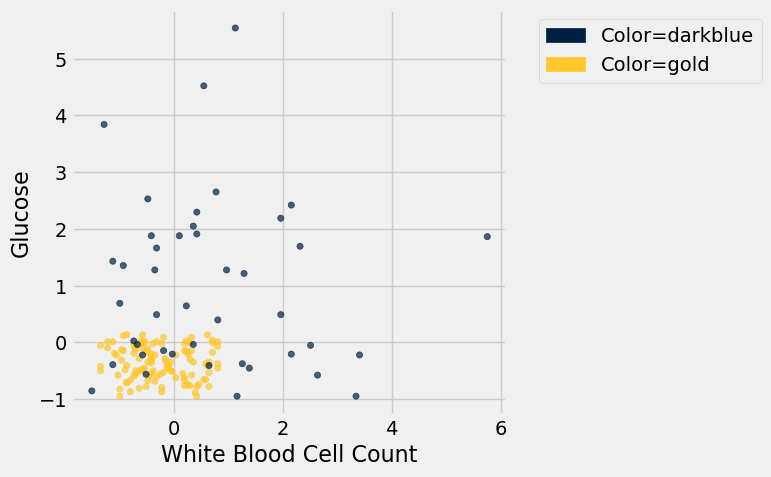

In [169]:
ckd.scatter('White Blood Cell Count', 'Glucose', group='Color')

In [170]:
ckd_with_distances.sort('Distance from Alice').take(np.arange(5))

Class,Hemoglobin,Glucose,White Blood Cell Count,Color,Distance from Alice
1,0.83975,1.2151,1.29101,darkblue,0.847601
1,-0.970162,1.27689,-0.345191,darkblue,0.986156
0,-0.0304002,0.0874074,-0.184779,gold,1.01305
0,0.14363,0.0874074,0.32854,gold,1.02273
1,-0.413266,2.04928,0.360623,darkblue,1.03534


The $5$ nearest neighbor algorithm will also pick `"darkblue"` (has ckd)

## Classifiying in multiple dimensions

**Distance in multiple ($n$) dimensions**

$$ \text{D} = \sqrt{(x_{1,0}-x_{1,1})^2 + ((x_{2,0}-x_{2,1})^2 + ... + (x_{n,0}-x_{n,1})^2} $$

**Generalizing our previous code**

In [171]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

In [172]:
def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(new_point), np.array(row))
    return attributes.apply(distance_from_point)

In [173]:
def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

In [174]:
def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

Checking that our procedure works by finding the nearest neighbor on the full `banknotes` dataset

In [175]:
banknotes.show(3)

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0


In [176]:
first_banknote = banknotes.drop('Class').row(0)
first_banknote

Row(WaveletVar=3.6215999999999999, WaveletSkew=8.6661000000000001, WaveletCurt=-2.8073000000000001, Entropy=-0.44699)

In [177]:
closest(banknotes,first_banknote,1)

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class,Distance
3.6216,8.6661,-2.8073,-0.44699,0,0


**Writing code for the algorithm portion (deciding what class we need to use)**

In [179]:
top5 = closest(banknotes,first_banknote,5)

In [180]:
ones = top5.where('Class', are.equal_to(1)).num_rows
zeros = top5.where('Class', are.equal_to(0)).num_rows

In [181]:
ones > zeros

False

In [182]:
def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

And finally, ... the complete procedure and algorithm, together.

In [183]:
def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [184]:
classify(banknotes, first_banknote, 10)

0

**STOP**

## Training and Testing

The training set and testing set need to be determined at random. In the following code, we are *permuting* the rows randomly and then extracting a test subset and trainng subset using `np.take()`. 

`ckd` dataset

In [185]:
shuffled_ckd = ckd.sample(with_replacement=False)

In [186]:
training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

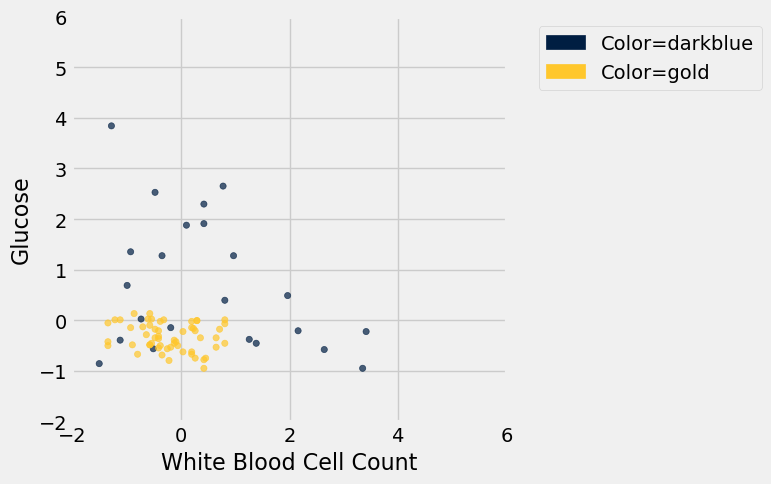

In [187]:
training.scatter('White Blood Cell Count', 'Glucose', group='Color')
plt.xlim(-2, 6)
plt.ylim(-2, 6);

`banknotes` dataset

In [203]:
halfway = round(banknotes.num_rows/2)
halfway

686

In [204]:
shuffled_banknotes = banknotes.sample(with_replacement=False)
training = shuffled_banknotes.take(np.arange(halfway))
testing = shuffled_banknotes.take(np.arange(halfway, banknotes.num_rows))

In [205]:
testing

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
1.4806,7.6377,-2.7876,-1.0341,0
3.1557,2.8908,0.59693,0.79825,0
-1.6988,-7.1163,5.7902,0.16723,1
-2.588,3.8654,-0.3336,-1.2797,1
-2.3142,2.0838,-0.46813,-1.6767,1
0.87256,9.2931,-0.7843,-2.1978,0
-1.5078,-7.3191,7.8981,1.2289,1
-1.0112,2.9984,-1.1664,-1.6185,1
0.68087,2.3259,4.9085,0.54998,0
0.18868,0.70148,-0.51182,0.0055892,1


In [215]:
first_testing_banknote = banknotes.drop('Class').row(0)

**Classifying one point from the testing dataset**

In [217]:
classify(training,first_testing_banknote,5)

0